
# Introduction



This is the notebook to accompany the course Applied Economic Analysis at Tilburg University. The idea is to bring economic concepts "alive" by programming them in python. The choice of topics is loosely based on Tirole (2017).

The point is not that we go into models in detail. Instead, we sketch the trade offs and then model these in python. We make graphs to explain the intuition. In this way, you learn both python and to use economics in a more "broad brush" fashion than "taking the third derivative".

When we go through the notes below, there will be **Questions** and **Assignments**. Questions we will typically do in class together. Assignments will take more time and you do these at home. If you have questions about these, come back to it in class.




# Python packages that we will be using



We need the following packages to run the code below. If you get an error saying that the package is not available, you can install it using either `pip install` or `conda install`.



In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import random
import wbdata as wb

plt.style.use('seaborn')
%matplotlib inline


# The market



This part is based on Tirole chapters: 1, 2, 6.




## why do we love the market?



Many (but not all) economists love the market as an organizing institution. This affection for markets is traced back by some to Adam Smith and his ["invisible hand"](https://en.wikipedia.org/wiki/Invisible_hand). Others may not think that the market is so great, but basically distrust other organizing institutions like a government. They will point, for instance, to the fall of communism in the [former Soviet Union](https://en.wikipedia.org/wiki/Revolutions_of_1989).

Although you, as an economist, have seen many market models already,
it may be illustrative to go back to basics. To understand the
advantages of the market, let us consider a very simple economy. We
focus on one type of product and there is an exogenous endowment of
this product (supply) equal to `number_of_goods`. Further, in this
economy there are `number_of_agents` agents who have a valuation for
this good which is randomly drawn from a normal distribution. An agent
can at max. consume one unit of the product and her utility is then
given by her valuation. The value of consuming zero units and the
additional value of consuming more than one unit both equal 0.

The vector `valuations` contains for each agent her valuation and we sort this vector such that the first agent has the highest valuation.



In [49]:
number_of_agents = 1000
number_of_goods = 100

valuations = np.array(sorted(pm.Normal.dist(100,20).random(size=number_of_agents),reverse = True))

In [9]:
np.std?

In [51]:
np.mean(pm.Normal.dist(100,20).random(size=1000000))

100.06555054659867

In [10]:
sorted([1,5,3,5,8])

[1, 3, 5, 5, 8]

Note that we are using [pymc3](http://docs.pymc.io/notebooks/getting_started) here to generate random numbers from a distribution. There are also other python libraries which can do this, e.g [scipy](https://scipy.org/). We use pymc3 as we will use it later for estimation as well.


**Question** What is the economic name for the following expression? To answer this question, you need to understand both how indexing works in python and which economic concept is captured by this expression.


In [52]:
valuations[number_of_goods]

125.38466153761544

Suppose that we have an omniscient social planner who knows the valuation of every agent in the economy. This planner aims to maximize the (unweighted) sum of agents' utilities.

**Question** Calculate the total welfare that this planner can achieve. Denote this value `max_welfare`.

In [29]:
max_welfare = np.sum(valuations[:number_of_goods])
print(max_welfare)

13687.336505315428


Hence, this is the best that we can do. It gives us an upperbound on the welfare that can be achieved. Having an omniscient social planner seems unrealistic, but perhaps there is an institution that can achieve this outcome without omniscient intervention. You guessed it&#x2026;


### market outcome



Now we compare the maximum welfare that a planner can achieve with the market outcome.

****Question**** Define a function `demand(p,valuations)` which has as arguments a price $p$ and a vector of agents' valuations. This function returns the number of agents who are willing to buy the product at price $p$. Since each agent who buys, buys exactly one unit in our set up, this function returns demand at each price.

In [79]:
def demand(p,valuations):
    return np.sum(valuations>p)

In [69]:
demand(100,valuations)

474

****Question**** Using `matplotlib` plot (fixed) supply and the function `demand` against price, where we maintain the economic convention of having quantity on the horizontal axis and price on the vertical axis.

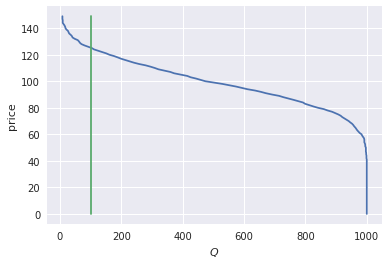

In [90]:
range_p=np.arange(0,150)
plt.plot([demand(p,valuations) for p in range_p],range_p, label='demand')
plt.plot([number_of_goods for p in range_p],range_p, label='supply')
plt.legend
plt.xlabel('$Q$')
plt.ylabel('price')
plt.show()


In [82]:
my_list = [1,2,3,4]
[x**2 for x in my_list]

[1, 4, 9, 16]

In order to calculate the equilibrium price, we define a function `excess_demand`. We will then look for the price where `excess_demand` equals 0; this is the equilibrium price.

In [92]:
def excess_demand(p,valuations,number_of_goods):
    return demand(p,valuations)-number_of_goods

In order to find the equilibrium price, we use from `scipy.optimize` the function [fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html). If you want to know more about solve, there are people at [stackoverflow](https://stackoverflow.com/questions/8739227/how-to-solve-a-pair-of-nonlinear-equations-using-python) discussing this function. Stackoverflow is generally a great resource if you are wondering how to solve a problem in python.


In [97]:
price = optimize.fsolve(lambda x: excess_demand(x,valuations,number_of_goods),120)
print("{0:.2f}".format(price[0]))


125.39


So, now we know the equilibrium price

****Question**** Calculate total welfare at this equilibrium price.

In [109]:
np.sum(valuations[:demand(price,valuations)])



13388.455457861246

****Question**** How does this welfare compare to the maximum welfare that the omniscient social planner can achieve? Recall that this level is:

In [1]:
"{0:.2f}".format(max_welfare)


### elastic demand and supply



Up till now we assumed that supply was inelastic: there was a given endowment of goods and this was auctioned off to consumers. Now we assume that some agents initially own the goods. However, these agents are not necessarily the ones that value the goods the most.

In particular, we give `number_of_goods` agents one unit of the good. They become suppliers.



In [9]:
random.shuffle(valuations)
valuations_supply = valuations[:number_of_goods]
valuations_demand = valuations[number_of_goods:]

**Question** Define a function `supply` which depends on the price and the valuations of the suppliers.

**Question** Use `matplotlib` to plot demand and supply in a single figure. 

**Question** Define the function `demand_minus_supply` which looks
like `excess_demand` above but now with elastic supply. The function
depends on the price, the valuations of people demanding the good and
the valuations of people supplying it.

Then use `fsolve` to find the equilibrium price.

**Question** How does the equilibrium price here compare to the equilibrium price above with exogenous supply? Is the price here higher? Why (not)? Is welfare higher here than above?



## why do others not love the market?



Although the results above look great, the assumptions we made, may not be realistic in every market. To illustrate, without saying so, we assumed above that the market is perfectly competitive and without external effects. Here we program three reasons why the market outcome may not necessarily lead to maximum welfare. First, we look at income inequality and the problem that this causes for the market. Then we consider market power and finally we model external effects.




### income distribution



In micro economics we usually do not do much with income distributions. Often because models where income distributions play a role are tricky to solve analytically. But here we program/simulate and hence we do not worry about analytical solutions.

Now in addition to the valuations introduced above (the utility an agent gets from consuming the good), we need an income distribution. The former determines the willingness to pay (wtp) for an agent, the latter the price an agent can pay. A consumer is willing to buy the product at a price $p$ if both her wtp and her income exceed $p$.

First, we randomly draw an income for each agent in the economy.



In [10]:
incomes = pm.Normal.dist(100,20).random(size=number_of_agents)

Next, we need to redefine demand, now denoted `demand_2` which takes into account both whether an agent values the good more than $p$ and whether she can afford $p$.

In [1]:
def afford(p,incomes):
    return incomes>p

def wtp(p,valuations):
    return valuations>p

def demand_2(p,valuations,incomes):
    return np.sum(afford(p,incomes)*wtp(p,valuations))

****Question**** Define the function `excess_demand_2` which depends on $p$, agents' valuations, incomes and number of goods (which we assume to be inelastically supplied again).

****Question**** Use `fsolve` to determine the equilibrium price in this case. Is this price higher or lower than above? Why?

****Question**** Calculate welfare in the market equilibrium. How does it compare to `max_welfare`?

****Assignment**** Model an economy where an increase in income inequality reduces welfare.



### market power



****Warning**** We are going to do a couple of things wrong in this section. No need to panic; this actually happens a lot when you are programming. Use your economic intuition to see where the mistakes are and correct them.

Suppose that we now give all the products to 1 agent who then owns `number_of_goods` units of this good. To simplify, we assume that this agent values the good at 0.

****Question**** Suppose we use the function `demand_minus_supply` defined above to calculate the equilibrium price. Would the equilibrium price increase due to market power? Why (not)?

Perhaps a monopolist would not use an auction to sell all the goods. Let's calculate the profits of the monopolist as a function of the price and the valuations of the agents.

In [11]:
def profit(p,valuations):
    return p*demand(p,valuations)

In [1]:
range_p = np.arange(0,140)

plt.plot(range_p, [profit(p,valuations) for p in range_p], label = "profit")
plt.legend()
plt.xlabel("$P$")
plt.ylabel("$\pi$")
plt.show()

It looks like the profit maximizing price is around 80. Recall the equilibrium price under perfect competition above:

In [ ]:
price

****Question**** Since when does a monopolist charge a lower price than a perfectly competitive market?

****Assignment**** Calculate the profit maximizing price in this case.


### merger simulation



This part is based on Tirole chapter 13.

In this section, we model a more standard oligopoly market with
Cournot competition. We start with three firms and then calculate what
happens if two firms merge such that only two firms are left in the
industry. Hence, we first calculate the equilibrium with three firms,
denoted by 1, 2 and 3. Then firms 2 and 3 merge so that we are left with 2 firms; denoted by
1 and 2.

We are interested in the effects of the merger on the equilibrium price.

We assume that before the merger each firm has constant marginal costs
equal to 0.3. We assume a simple linear (inverse) demand curve of the
form $p=1-Q$ where $p$ denotes price and $Q$ total output on the market.
Total output equals the sum of each firm's output: $Q= q_1 + q_2+q_3$.

The function `reaction` gives the optimal reaction of a firm to the total output `Q_other` from its competitors. In this function, we use the routine [fminbound](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fminbound.html). Python does not have maximization routines, hence we minimize "minus profits" (which is the same from a mathematical point of view). The parameters `0,1` in this routine give the bounds over which we optimize. Since demand is of the form $p(Q)=1-Q$, we know that no firm will choose $q>1$; further we also know that $q \geq 0$.

The fixed point makes sure that for each of the three firms, their output level is equal to its optimal reaction to the output levels of its competitors. If each firm plays its optimal response, given the actions of the other players, we have a Nash equilibrium.



In [34]:
c0 = 0.3
vector_c = [c0]*3

def p(Q):
    return 1 - Q

def costs(q,c):
    return c*q

def profits(q,Q_other,c):
    return p(q+Q_other)*q-costs(q,c)

def reaction(Q_other,c):
    q1 =  optimize.fminbound(lambda x: -profits(x,Q_other,c),0,1,full_output=1)
    return q1[0]

def fixed_point_three_firms(vector_q,vector_c):
    return [vector_q[0]-reaction(vector_q[1]+vector_q[2],vector_c[0]),
            vector_q[1]-reaction(vector_q[0]+vector_q[2],vector_c[1]),
            vector_q[2]-reaction(vector_q[0]+vector_q[1],vector_c[2])]

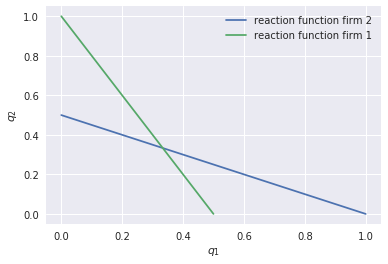

In [35]:
range_Q = np.arange(0,1.1,0.1)
plt.plot(range_Q,[reaction(x,0) for x in range_Q],label='reaction function firm 2')
plt.plot([reaction(x,0) for x in range_Q],range_Q,label ='reaction function firm 1')
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.legend()
plt.show()



In [16]:
fixed_point_three_firms(np.array([0.2,0.3,0.1]),vector_c)

[0.050000000000000044, 0.09999999999999998, -1.942890293094024e-16]

We calculate the equilibrium output level, price and the Herfindahl index. The Herhindahl index is defined as the sum of squared market shares:

\begin{equation}
\label{eq:1}
H = \sum_j \left( \frac{q_j}{\sum_i q_i} \right)^{2}
\end{equation}

If we have $n$ symmtric firms, we have $H = 1/n$. Hence, more competition in the form of more firms in the market leads to a lower Herfindahl index.


In [36]:
initial_guess_3 = [0,0,0]

Q0 = np.sum(optimize.fsolve(lambda q: fixed_point_three_firms(q,vector_c), initial_guess_3))
P0 = p(Q0)
H0 = 3*(1.0/3.0)**2

print("Before the merger")
print("=================")
print("total output: {:.3f}".format(Q0))
print("equil. price: {:.3f}".format(P0))
print("Herfn. index: {:.3f}".format(H0))

Before the merger
total output: 0.525
equil. price: 0.475
Herfn. index: 0.333


****Question**** Define a function `fixed_point_two_firms` with the same
structure as the function `fixed_point_three_firms` above, except that
it derives the equilibrium output levels for a duopoly (two firms).
Test this function by showing that each of the two firms produces
0.3333 in case both firms have zero costs; use `fsolve` as above.

A competition authority (CA) is asked to evaluate the effects
of a merger between firms 2 and 3. Firms 2 and 3 claim that by merging
they can reduce their constant marginal costs. But it is not clear by
how much they will reduce their costs.

The CA assumes that the marginal cost level of the merged firm is
uniformly distributed between 0 and the current marginal cost level
`c0`. The merger will not affect the marginal cost level of firm 1 which
does not merge. Firm 1's cost level remains `c0`.

The next cell generates a vector of cost levels for the merged firm,
denoted `c_after_merger`. Then it calculates the equilibrium output
levels for (the non-merging) firm 1 and (the merged) firm 2.

In [40]:
def fixed_point_two_firms(vector_q,vector_c):
    return [vector_q[0]-reaction(vector_q[1],vector_c[0]),
            vector_q[1]-reaction(vector_q[0],vector_c[1])]


In [41]:
c_after_merger = pm.Uniform.dist(0,c0).random(size = 100)

initial_guess = [0.2,0.2]

q1_after_merger = [optimize.fsolve(lambda q: fixed_point_two_firms(q,[c0,c]), initial_guess)[0] for c in c_after_merger]
q2_after_merger = [optimize.fsolve(lambda q: fixed_point_two_firms(q,[c0,c]), initial_guess)[1] for c in c_after_merger]

In [42]:
df_after_merger = pd.DataFrame({'c_merged_firm': c_after_merger, 'output_non_merging_firm':q1_after_merger,\
                               'output_merged_firm':q2_after_merger})

In [21]:
c_after_merger

array([0.02740402, 0.01630359, 0.14155666, 0.25126686, 0.2942235 ,
       0.00619615, 0.26166805, 0.00462451, 0.06298872, 0.10149636,
       0.17722605, 0.18231236, 0.18886593, 0.12102269, 0.2716498 ,
       0.09292479, 0.14487016, 0.07371096, 0.24086814, 0.0012702 ,
       0.25544333, 0.23243437, 0.29170742, 0.08774429, 0.21002435,
       0.00036759, 0.27739126, 0.09433018, 0.18258014, 0.1811388 ,
       0.03340454, 0.18410267, 0.13917393, 0.1773118 , 0.02115916,
       0.28466316, 0.03588437, 0.26887133, 0.13046495, 0.29589527,
       0.21046795, 0.18942423, 0.13614813, 0.20339275, 0.04855597,
       0.13346941, 0.27281366, 0.24156214, 0.29096154, 0.29307783,
       0.11280963, 0.29235443, 0.13906225, 0.04874677, 0.25626882,
       0.27652237, 0.28904454, 0.12775373, 0.07200288, 0.1275451 ,
       0.07703804, 0.02191121, 0.20380601, 0.17768752, 0.13940683,
       0.07050654, 0.09610252, 0.27839257, 0.22787508, 0.0401221 ,
       0.2044931 , 0.02227741, 0.12112239, 0.05025642, 0.02141

**Question** Create a dataframe called `df_after_merger` with
three columns: `c_merged_firm`, `output_non_merging_firm`,
`output_merged_firm` containing resp. the cost level of the merged firm,
the output level of firm 1 and the output level of firm 2.

In [45]:
df_after_merger['Q']=df_after_merger.output_merged_firm+df_after_merger.output_non_merging_firm

In [43]:
df_after_merger.head()

,c_merged_firm,output_merged_firm,output_non_merging_firm
0,0.246934,0.268711,0.215645
1,0.221682,0.285545,0.207227
2,0.083169,0.377888,0.161056
3,0.106953,0.362031,0.168984
4,0.274574,0.250284,0.224858


**Question** Add three columns to the dataframe with resp. total
equilibrium output on the market, `Q`, equilibrium price, `P` and the
Herfindahl index, `H`.

In [48]:
df_after_merger['Q']=df_after_merger.output_merged_firm+df_after_merger.output_non_merging_firm
df_after_merger['P']=p(df_after_merger['Q'])
df_after_merger['H']=(df_after_merger.output_merged_firm/df_after_merger.Q)**2+\
(df_after_merger.output_non_merging_firm/df_after_merger.Q)**2

**Question** Make a histogram of the equilibrium price `P` after
the merger. Also indicate in the histogram the equilibrium price before
the merger `P0`. Label the horizontal axis with $P$.

[hint: you may want to use matplotlib's `hist`, `vlines` and `legend` to
make this graph (e.g use google to find these functions); but feel free
to use something else]

In [50]:
plt.hist?

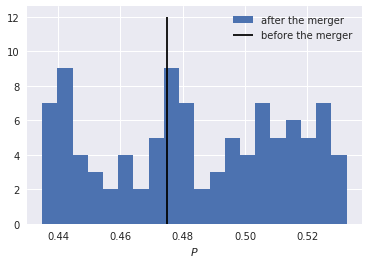

In [54]:
plt.hist(df_after_merger.P, bins=20,label='after the merger')
plt.vlines(P0,0,12,label='before the merger')
plt.legend()
plt.xlabel('$P$')
plt.show()

**Excersise** Explain why sometimes the equilibrium price after
the merger exceeds the equilibrium price before the merger and sometimes
it is lower than the pre-merger price.

What is calculated in the following cell?

In [56]:
len(df_after_merger.P)

100

In [55]:
np.sum(df_after_merger.P < P0)/len(df_after_merger.P)

0.37

****Question**** Make a graph with the Herfindahl index on the
horizontal axis and the equilibrium price on the vertical axis. This is
straightforward for $(H,P)$ after the merger as both values are in the
dataframe. Add in another color, the pre-merger combination `(H0,P0)`
that we calculated above.

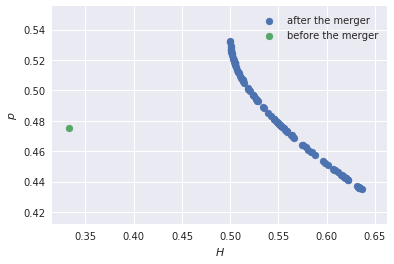

In [71]:
plt.scatter(df_after_merger.H, df_after_merger.P,label='after the merger')
plt.scatter(H0,P0,label='before the merger')
plt.xlabel('$H$')
plt.ylabel('$p$')
plt.legend()

plt.show()

****Question**** What does the figure above illustrate about the relation
between the Herfindahl index and the equilibrium price? To illustrate,
some people think that lower values of the Herfindahl index are
associated with more competitive outcome. Would you agree with this?


### external effects



A final reason why people are not always enthusiastic about markets is the presence of external effects. One can think of pollution associated with the production of a good. We model this as follows. Assume a monopolist can produce the product at cost $c q$. But production leads to an external effect equal to $\gamma q$. Hence, the social cost of production equals $(c+\gamma)q$

We can model this as follows.



In [16]:
number_of_agents = 1000
valuations = np.array(sorted(pm.Normal.dist(100,20).random(size=number_of_agents),reverse = True))

def demand(p,valuations):
    return sum(valuations>p)

c = 30
γ = 80
def costs(q):
    return c*q

def externality(q):
    return γ*q

def profit_c(p,valuations):
    return p*demand(p,valuations)-costs(demand(p,valuations))

def welfare_e(p,valuations):
    return np.sum(valuations[:demand(p,valuations)])-costs(demand(p,valuations))-externality(demand(p,valuations))

****Question**** Show graphically that the welfare maximizing price exceeds the profit maximizing price.

****Question**** What is the interpretation of this result? Which policy instrument can the government use here?


# Asymmetric information



Tirole chapter 15.

One of the reasons why markets (or other institutions for that matter) work less well than a naive observer may think is asymmetric information. We consider here both adverse selection and moral hazard. Adverse selection we analyze in the context of insurance and moral hazard in the context of taxation.




## adverse selection



****Question**** What is adverse selection?

Consider an economy with `number_of_agents` agents. Each agent has an endowment/income equal to `income` and faces a potential loss of the size `cost`. Agents differ in the probability $\pi$ of this loss. We randomly draw 50 values for $\pi$ assuming it is uniformly distributed on $[0,1]$.

Further, agents have a utility function of the form $u(x)=x^{\rho}$.



In [73]:
income = 1.1
cost = 1
ρ = 0.1
def u(x):
    return x**ρ

number_of_agents = 50

π = pm.Uniform.dist(0.0,1.0).random(size = number_of_agents)
π.sort()

Since we assume that $\rho \in \langle 0, 1 \rangle$, agents are risk averse and would like to buy insurance which covers the loss. We assume that insurance covers the loss completely at a premium $\sigma$. As we assume that the probability of loss, $\pi$, is exogenous, there is no reason to have co-payments of any sort.

An agent buys insurance if and only if

\begin{equation}
\label{eq:2}
u(\text{income}-\sigma) > \pi u(\text{income}-\text{cost}) + (1-\pi) u(\text{income})
\end{equation}

**Question** Define a function `insurance_demand` that returns the number of agents buying insurance as a function of the premium $\sigma$.

In [75]:
def insurance_demand(σ):
    return np.sum(u(income-σ)>π*u(income-cost)+(1-π)*u(income))

insurance_demand(0.3)

45

We assume that this insurance market is perfectly competitive. That is, for each quantity supplied, insurance companies compete down the price such that the premium equals the average (expected) cost of the agents buying insurance.

**Question** Explain the code of the following function.

In [76]:
def insurance_supply(Q):
    return np.mean(π[-Q:])*cost

We plot demand and supply in one figure. In addition, we plot the marginal costs curve.



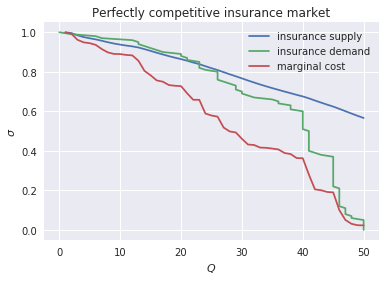

In [77]:
range_Q = np.arange(1,number_of_agents+1,1)
range_sigma = np.arange(0,1.01,0.01)
plt.plot(range_Q,[insurance_supply(Q) for Q in range_Q],label="insurance supply")
plt.plot([insurance_demand(sigma) for sigma in range_sigma],range_sigma,label="insurance demand")
plt.plot(range_Q,[π[-Q]*cost for Q in range_Q],label="marginal cost")
plt.legend()
plt.xlabel('$Q$')
plt.ylabel('$\sigma$')
plt.title('Perfectly competitive insurance market')
plt.show()

****Question**** Interpret this figure. In particular, 

-   explain why all curves are downward sloping (is supply not usually upward sloping?)
-   what is approx. the equilibrium premium $\sigma$?
-   is the market outcome efficient?
-   what can we learn from the marginal cost curve?

****Assignment**** Show graphically the effect of an increase in income on the market outcome. Does the inefficiency increase or decrease with income? Why?




## moral hazard: optimal taxation



With moral hazard, agents take hidden actions. The actions that they take are affected by the incentives that they face. We consider this in the context of taxation. 

People differ in their productivity. For some people it is easy to generate a gross income $x$, for others generating such an income would be very costly in terms of effort. In the real world, such differences in productivity can be caused by IQ, education, health status etc. Here, we simply model this as an effort cost. People with a high effort cost have lower productivity than people with low effort costs. We assume that the effort cost is log-normally distributed. 

The government uses a linear tax schedule: $\tau x - \tau_0$. Hence, when you have a gross income $x$, your net income equals $(1-\tau)x+\tau_0$. Where we assume that for the economy as a whole the tax revenue is redistributed among the population. Hence, `number_of_agents` times $\tau_0$ has to equal the total revenue from the marginal tax rate $\tau$.

Agents maximize their utility by choosing production $x$:

\begin{equation}
\label{eq:3}
\max_{x \geq 0} (1-\tau)x+\tau_0 - cx^2
\end{equation}

where agents differ in $c$ and $c$ is not observable.

These two aspects are important: if $c$ were observable or if everyone was symmetric (had the same $c$) taxation would be easy. To see why, first note that income $x$ is apparently observable since taxation depends on it. Hence, the government could say to an agent $c$: I want you to produce income $x$ and you give me a share $\tau$ of this income. 

In our set-up with heterogeneity in $c$ and $c$ unobservable, the government cannot force people to generate income $x$ because some of these agents may have such a high $c$ that this is inefficient (or even impossible).

Hence, the government sets the tax schedule (in our case linear) and allows each agent to choose her own production level. The higher $\tau$, the lower an agent's production will be.



In [22]:
number_of_agents = 200
effort_costs = pm.Lognormal.dist(mu=0.0,sd=0.5).random(size=number_of_agents)
def effort(c,τ):
    sol = optimize.minimize(lambda x: -(x*(1-τ)-c*x**2),1)
    return sol.x

We use the following welfare function:

\begin{equation}
\label{eq:4}
W = \left(\sum_i ( (1-\tau)x_i + \tau_0 - c_i x_i^2)^{\rho} \right)^{1/\rho}
\end{equation}

With $\rho=1$, the social planner just maximizes the sum of utility. With $\rho<1$, the planner has a taste for redistribution: agents with low utility get a relatively high weight in this welfare function.

The function `Welfare` first calculates for a given $\tau$, what the value of $\tau_0$ is (using budget balance for the government). Then for these values of $\tau$ and $\tau_{0}$, $W$ is calculated.

In [1]:
def Welfare(τ,ρ):
    τ_0 = np.mean([τ*effort(c,τ) for c in effort_costs])
    return (np.sum([((1-τ)*effort(c,τ)+τ_0 - c*effort(c,τ)**2)**ρ for c in effort_costs]))**(1/ρ)

****Question**** Plot `Welfare` as a function of $\tau$ for $\rho=1$. What is the welfare maximizing tax rate? Why?

****Question**** What happens to the optimal tax rate as $\rho<1$ falls?

****Assignment**** Redefine the function `Welfare` above such that it uses [Rawls' criterion](https://en.wikipedia.org/wiki/A_Theory_of_Justice) of maximizing the utility of the person who is worse off in society. Further, suppose that the government needs $g$ per head to finance a public good. What is the effect of $g$ on the optimal marginal tax rate?



# Financial crisis



Tirole chapters: 11, 12

We will look at two aspects of the financial crisis. First, why are financial markets problematic in the first place. Second, many people claim that the crisis was (partly) caused by the bonus contracts used by banks. Why do banks offer their employees such contracts?




## Why is there a problem in financial markets?



The first problem in financial (and other) markets is limited liability. When banks go bankrupt they "only" loose their equity even if the debts that they accumulated exceed their equity. We run some simulations to show that this leads to banks taking excessive risks from a social point of view.

Let $x$ denote an investment opportunity: $x$ is a vector with dimension 1000. That is, we assume that there are 1000 states of the world and $x$ gives us the return in each of these states of the world. To find the expected `profit`, we take the average over the return in all these states of the world. However, if $x$ is "very negative" (a big loss), the bank goes bankrupt and the owners only loose their `equity`.



In [24]:
def profit(x,equity=0):
    return np.mean(np.maximum(x,-equity))

**Question** Plot the function `profit` for the case where `equity`=10 and $x$ is a scalar.

Note that although we think of $x$ as a vector (and we will use this in a second), python does not know this nor does it care. Hence, we can plot `profit` as a function of the scalar $x$.


**Question** Create an investment opportunity `vector_returns` where the returns are normally distributed with mean $-10$ and standard deviation 100. As mentioned above, we assume that there are 1000 states of the world.

**Question** Calculate the expected (social) return from this investment `vector_returns`.

**Question** Calculate the expected profits of the `vector_returns`. Compare the outcome to the one above. What is the interpretation?

**Question** Explain what is coded in the following code cell. E.g. what is the point of the 10000?

In [1]:
v_std = np.arange(0,200,1)
v_returns = [pm.Normal.dist(-10,std).random(size=1000) for std in v_std]
plt.scatter([np.std(vx) for vx in v_returns],[profit(vx) for vx in v_returns], label="no equity")
plt.scatter([np.std(vx) for vx in v_returns],[profit(vx,60) for vx in v_returns], label="equity equals 60")
plt.scatter([np.std(vx) for vx in v_returns],[profit(vx,10000) for vx in v_returns], label="social value")
plt.xlabel('$\sigma$')
plt.ylabel('return')
plt.legend()
plt.show()

****Question**** Explain the economic intuition/interpretation of the graph above.




## Why these bonus contracts?



Bonus contracts are generally a reaction to asymmetric information. Let's first consider moral hazard.




### moral hazard



How do your employees choose their investment opportunities? There are a number of things that you may worry about. Suppose you would pay everyone a fixed salary that does not depend on performance. Then your employees may randomly pick an investment opportunity without analyzing whether this is the best opportunity. The rest of the time, they simply enjoy the sun. Or they may invest your money in the new webshop of their brother in law. This may increase their status in their family but does not necessarily boost your profits. 

Since it is hard for banks to monitor exactly what investment opportunities their employees choose and how risky these are, it seems a good idea to give them some incentive to choose the right investment. One way to do this is to reward good outcomes. That is, the higher the return is, the higher their income will be. That is, employees get a bonus for good *outcomes*. Not for investments with a high expected outcome because that is hard to monitor.

Tirole (2017) claims that before the financial crisis investments bank offered high bonuses to attract talented employees (page 345). These bonuses led to inefficient risky behaviour by these employees. But why should competition for talent lead to inefficiencies?

We follow Bijlsma et al. (2018) to model this question. The structure of this model is comparable to our analysis of moral hazard in optimal taxation above. For a given bonus contract, employees choose the investment project that maximizes their own income. Knowing this, the bank sets the bonus contract to maximize its profits.

Assume that there are 3 states of the world: the good state where the bank receives $y_g$ as return on the investment; a bad state where the bank makes a loss $y_b <0$ on the project and an "average state" where the bank earns $y_a \in \langle 0, y_g \rangle$. The employee can choose from a set of investment projects that differ in their probabilities over these 3 states of the world. We model this as follows. 

Projects are indexed with their probability $q \in [0,1]$ of the "average state". For a given $q$, the probabilities of the other two states are given by $q_g = \alpha (1-q)(1+q)$ where $\alpha \in [0,0.5]$ denotes the "talent" of the employee and $q_b = 1- q - q_g$ resp. More talented agents (higher $\alpha$) have a higher probability of the good state and a lower probability of the bad state for a given probability $q_a = q$.

The bank cannot observe the project choice $q$ of the employee but it can observe and contract upon the outcome $y_{g,a,b}$. Hence, it can specify a wage for each state $w_{g,a,b}$. The limited liability of the agent is modelled as $w_g,w_a,w_b \geq 0$. The bank cannot fine ($w<0$) its employee. 

****Question**** What does a contract with a constant wage look like?

We specify values for $y_{g,a,b}$, define the functions for $q_g$ and $q_b$.



In [25]:
y_a = 1
y_g = 10
y_b = -20

def q_g(q,ability):
    return ability*(1-q)*(1+q)

def q_b(q,ability):
    return 1 - q - q_g(q,ability)

**Question** Define a function `q_choice` of the wage vector $w$ and `ability` of the employee. [hint: the vector $w$ only needs to have 2 dimensions]

Given the function `q_choice`, the function `bank_choices` derives the optimal wage vector $w=[w_a,w_g]$ for a given `ability` of the employee. Then contract derives optimal risk choice $q$ as a function of `ability` and the outside option of the employee. If the outside option of the employee is so high that it is no longer profitable for the bank to hire this employee, the function returns $-1$.

In [1]:
initial_guess = [0.5,1.5]

def bank_choices(ability):
    opt_w = optimize.fmin(lambda x: -(q_g(q_choice(x,ability),ability)*y_g + q_choice(x,ability)*y_a + (1-q_choice(x,ability)-q_g(q_choice(x,ability),ability))*y_b),initial_guess, disp=0)
    return [opt_w,q_choice(opt_w,ability)]

def contract(ability,outside_option):
    q = bank_choices(ability)[1]
    profit = q*y_a + q_g(q,ability)*y_g + q_b(q,ability)*y_b
    if profit - outside_option >= 0:
        q_out = q
    else:
        q_out = -1
    return q_out

**Question** Plot the optimal $q$ for the bank as a function of the outside option of an employee with `ability` equal to $0.5$. Do this for outside options between 0 and 4.

**Question** Do we see that as competition for talented employees intensifies, thereby increasing their outside options, banks tend to offer them more risky contracts? Why (not)?

Now we add the second form of asymmetric information: adverse selection. Before we do this and in order to speed up the code below, we will also solve the problem above analytically.

The bank solves the following optimization problem:

\begin{equation}
\label{eq:5}
\max_q qy_a + \alpha (1-q)(1+q)y_g + (1-q-\alpha (1-q)(1+q)) y_b
\end{equation}

**Question** By taking the first order condition for $q$, show that the bank would like to implement:

\begin{equation}
\label{eq:6}
q = \frac{y_a-y_b}{2\alpha(y_g-y_b)}
\end{equation}

What is the optimal $q$ for a trader with $\alpha=0.5$?

**Question** For a social planner, the damage in the bad state ($y_b$) may be bigger (i.e. more negative) than for the bank. The bank only loses its equity, the government may need to bail out the bank or there can be a bank run if one bank collapses. What is the effect on the optimal $q$ of lower (more negative) $y_b$?

**Question** A less talented trader has lower $\alpha$; what is the effect on $q$?

**Question** Use the equation for $q$ above to find the $q$ chosen by a worker facing a bonus contract with $w_a,w_g$.


### moral hazard and adverse selection



Suppose now that there are two types of traders: one talented and the other less so. The bank cannot distinguish these types by just observing them. They may have the same education degrees and work experience. But some have a "knack" for observing opportunities and taking risks, which the others lack.

The bank is willing to pay a lot to remunerate the top traders, but not the average ones. However, the average ones will try to look like the top traders to also earn these stellar incomes. To avoid the average ones to take these risks, the bank needs to pay them enough to stop them from mimicking the top traders.

To simplify the analysis here, we make a number of assumptions:

-   first, the fraction of top traders equals 0.5
-   the outside option of the average traders is so low that top traders are never interested in mimicking average traders; but average traders do want to mimic top traders
-   top traders are only paid in terms of bonus payments ($w_a,w_g$); not a fixed income component
-   when we optimize over the top trader's wages below, we take the $q$ for the average traders and the profit they generate as given (and equal to their optimal profit for the bank)

The last two points can actually be proved (in this sense, they are not assumptions); but we are not going to worry about this here.

Since top traders only receive bonus payments, it must be the case that:

\begin{equation}
\label{eq:7}
\text{outside_option}=qw_a + \alpha_h (1-q)(1+q) w_g
\end{equation}

Defining the bonus ratio are $R=w_a/w_g$, we see that

\begin{equation}
\label{eq:8}
w_g = \frac{\text{outside_option}}{qR+\alpha_h(1-q)(1+q)}
\end{equation}

and hence we find that $w_a = R w_g$.

The code below derives the optimal value of this bonus ratio $R$.

**Question** Explain why $R$ can be interpreted as the "riskiness" of the bonus contract.



In [26]:
α_l = 0.1
α_h = 0.5

def profit(R,outside_option):
    q = R/(2*α_h)
    w_g = outside_option/(R*q + q_g(q,α_h))
    mimic_q = R/(2*α_l)
    w_a = R*w_g
    wage_l = mimic_q*w_a+q_g(mimic_q,α_l)*w_g
    profit = 0.5*(q*y_a + q_g(q,α_h)*y_g+(1-q-q_g(q,α_h))*y_b - outside_option) - 0.5*wage_l
    return [profit, q]

initial_guess = 0.5

def outcome_h(outside_option):
    wages_h = optimize.fmin(lambda x: -profit(x,outside_option)[0],initial_guess, disp=0)
    return profit(wages_h,outside_option)[1]

Finally, we plot the optimal value of $q$ as a function of the outside option.


In [1]:
plt.plot(range_outside_options,[outcome_h(o) for o in range_outside_options])
plt.xlabel('outside option')
plt.ylabel('probability of safe choice $q_a$')
plt.show()

**Question** What does the graph above show? What is the intuition for this?



# Using python for empirical research



We consider two ways in which python can be useful for empirical research. First, the use of API's to download datasets. Second, the use of hacker statistics.




## API's to get data



A good reason to use python for data analysis is the option to get on-line data directly into your notebook without going to the website first to download this data. A number of institutes have such python API's. To illustrate this, we use the Worldbank API as described on [this website](http://wbdata.readthedocs.io/en/latest/).

The advantage of doing your analysis in this way is that your research becomes better reproducible. Everyone can run the same code and then go through your code of data cleaning steps to end up with the same data set. If instead you first download the data to your computer, then use excel to clean the data and then start analyzing it (say, with stata), no one will be able to reproduce the exact steps that you have taken.

To illustrate the Worldbank API, we will look at the development over time of inequality in gdp per head. So we want measures of gdp per head. The API allows us to search for such indicators in the Worldbank data set. The column on the left gives the name of the variables (that we will use below to download the data); the column on the right explains what the variable provides.



In [2]:
wb.search_indicators("gdp per capita")

6.0.GDPpc_constant      	GDP per capita, PPP (constant 2011 international $) 
FB.DPT.INSU.PC.ZS       	Deposit insurance coverage (% of GDP per capita)
NY.GDP.PCAP.PP.KD.ZG    	GDP per capita, PPP annual growth (%)
NY.GDP.PCAP.PP.KD.87    	GDP per capita, PPP (constant 1987 international $)
NY.GDP.PCAP.PP.KD       	GDP per capita, PPP (constant 2011 international $)
NY.GDP.PCAP.PP.CD       	GDP per capita, PPP (current international $)
NY.GDP.PCAP.KN          	GDP per capita (constant LCU)
NY.GDP.PCAP.KD.ZG       	GDP per capita growth (annual %)
NY.GDP.PCAP.KD          	GDP per capita (constant 2010 US$)
NY.GDP.PCAP.CN          	GDP per capita (current LCU)
NY.GDP.PCAP.CD          	GDP per capita (current US$)
NV.AGR.PCAP.KD.ZG       	Real agricultural GDP per capita growth rate (%)
SE.XPD.TERT.PC.ZS       	Government expenditure per student, tertiary (% of GDP per capita)
SE.XPD.SECO.PC.ZS       	Government expenditure per student, secondary (% of GDP per capita)
SE.XPD.PRIM.PC.ZS   

Let's say that we are interested in "GDP per capita, PPP (constant 2011 international $)", we specify this indicator in a dictionary where the key is the "official name" of the variable and the value is the way that we want to refer to the variable (in this case: "GDP\_per\_head").

With `get_dataframe` we actually download the data into the dataframe `df_wb`. We reset the index in this case (just see what happens to the dataframe if you don't do this). And we look at the first 5 rows to get an idea of what the data are.



In [3]:
indicators = {"NY.GDP.PCAP.PP.KD": "GDP_per_head"}
df_wb = wb.get_dataframe(indicators, convert_date=True)
df_wb.reset_index(inplace = True)
df_wb.head()

,country,date,GDP_per_head
0,Arab World,2017-01-01,15413.791998
1,Arab World,2016-01-01,15500.530523
2,Arab World,2015-01-01,15342.766482
3,Arab World,2014-01-01,15199.008915
4,Arab World,2013-01-01,15174.101703


**Question** What do the last 10 rows look like?

If you like the dataframe that you have downloaded from the web, you can save it with pandas `to_csv`. We save the data in the subdirectory "data".

In [29]:
df_wb.to_csv('data/worldbank_data_gdp_per_capita.csv')

Let's compare the distribution of gdp per head in 1990 with the distribution in 2017. In order to illustrate how we can combine dataframes in pandas, we first define separate dataframes for the years 1990 and 2017.


In [4]:
df_1990=df_wb[df_wb['date']=='1990-01-01']
df_2017=df_wb[df_wb['date']=='2017-01-01']

**Question** What does the dataframe `df_1990` look like?

Both dataframes have a column `country`. Hence, we can merge the dataframes on this column. There are a number of `how` methods, here we use 'inner' which means that only countries that are present in both datasets will be in `df_merged`. To distinguish the columns, like `GDP_per_head` from the two dataframes, we can provide suffixes. All columns from `df_1990` (except for `country`) will be suffixed with '\_1990'; and similarly for 2017.

In [5]:
df_merged = pd.merge(df_1990, df_2017, on=['country'], suffixes=['_1990', '_2017'], how='inner')

**Question** To see how the suffixes work, check what `df_merged` looks like.

**Question** Plot GPD per head in 1990 against GDP per head in 2017. What do you conclude about the development in inequality in these 27 years?

You may wonder which observations ("dots") correspond to which countries. For this we need a plotting library that is more sophisticated on interactions than `matplotlib`. A number of these libraries are available; here we consider [bokeh](https://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html). If you want to know more about bokeh, there is a [datacamp course](https://www.datacamp.com/courses/interactive-data-visualization-with-bokeh).

In [6]:
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool
output_notebook()

hover = HoverTool(tooltips=[
     ('country','@country'),
     ])

plot = figure(tools=[hover])
plot.circle('GDP_per_head_1990','GDP_per_head_2017',
    size=10, source=df_merged)
output_file('inequality.html')
show(plot)

Loading BokehJS ...


## Hacker statistics



In the last chapter of the Datacamp course [Intermediate Python for Data Science](https://www.datacamp.com/courses/intermediate-python-for-data-science) you have seen hacker statistics. The idea is to simulate a random process, say, 10,000 times. Then if you want to know the probability that a certain condition is satisfied (say, number of heads bigger than 10 when you throw a coin 15 times), you calculate the number of outcomes where this condition is satisfied and divide it by 10,000.

If you can program, you can recap all the statistics that you were taught (and probably forgot).




### high school puzzles



Remember when you did statistics at high school? "In a dark cupboard there are 10 red and 20 white socks&#x2026;", "you throw dice 20 times and &#x2026;" etc.

Then you had to do the most counter-intuitive mental jumping around to "understand" why the outcome was "one third".

When you can program, there is no need for this anymore. Program the probability process, replicate it 10,000 times and see what the frequency of an event is.

We will practice this, using the example given in this [Ted talk](https://www.ted.com/talks/peter_donnelly_shows_how_stats_fool_juries#t-479966).

-   Experiment 1: you throw a coin a number of times and wait for the pattern "HTH" to emerge;
-   Experiment 2: you throw a coin a number of times and wait for the pattern "HTT" to emerge.

In expectation, which experiment is over sooner (i.e. takes less throws to see the required pattern)?

**Question** Define a function `check` which checks whether a list `coin_throws` ends with the required `pattern` (also a list).

[hint: in terms of python, you need to use your knowledge of "slicing" lists]



**Question** Explain what the following code block does:

In [1]:
outcomes = ['H','T']

def waiting_time(pattern):
    throws = list(np.random.choice(outcomes,size=3))
    while not check(throws,pattern):
        throws.append(random.choice(outcomes))
    return len(throws)

**Question** Create an empty list `waiting_times`. Then run the first experiment 50,000 times. Record the waiting time for the pattern `['H','T','H']` to appear &#x2013;for each of these 50,000 experiments&#x2013; in the list `waiting_times`. Calculate the average waiting time and give a histogram for the waiting times.

**Question** Do the same as the previous question for experiment 2.

**Question** Which experiment leads to the lower waiting time in expectation? Do you have an intuition?


### statistics



Let's start simple. Suppose we have two normally distributed variables $x,y$ with $\mu_x = 10, \mu_y = 20, \sigma_x = 3, \sigma_y =4$. We are interested in the variable $z = x+y$. Suppose you forgot what you know about the sum of normal distributions and wondered what the expectation and standard deviation is of $z$.

**Question** Simulate $z$ and calculate its mean and standard deviation.

And, indeed, we know that $\mu_z = \mu_x + \mu_y$ and $\sigma_z = \sqrt{\sigma_x^2 + \sigma_y^2}$

**Question** Let $x$ be normally distributed with $\mu_x=0,\sigma_x=1$ and $y$ has a poisson distribution with $\lambda_y=5$. What is the expectation and standard deviation of $z=xy$?

Many students find it to hard to think of the distribution of an average or the distribution of a standard deviation.

**Question** Consider the following code block and try to understand what it does.

In [34]:
mu = 1000
sd = 100
number_of_samples=250

def moments(n):
    samples = pm.Normal.dist(mu,sd).random(size=(number_of_samples,n))
    mus = samples.mean(axis=1)
    std = mus.std()
    return [mus,std]

**Question** Redefine the function `my_function(n)` such that it goes through the points in the figure below. 

[hint: you do not need to fit a function, just use your knowledge of statistics]

In [35]:
def my_function(n):
    return 20


We plot the second element of the function `moments` against $n$ and the function `my_function`.



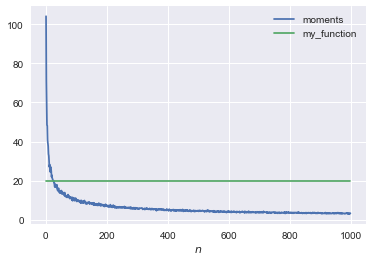

In [36]:
range_n = np.arange(1,1000)

plt.plot(range_n,[moments(n)[1] for n in range_n], label='moments')
plt.plot(range_n,[my_function(n) for n in range_n], label='my_function')
plt.legend()
plt.xlabel('$n$')
plt.show()

**Question** Explain what the following distribution below is.

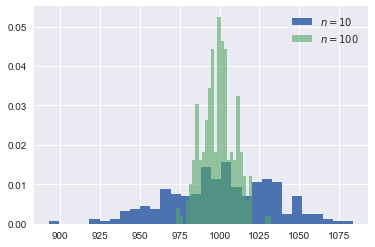

In [37]:
plt.hist(moments(10)[0],bins=30,label='$n=10$',density=True)
plt.hist(moments(100)[0],bins=30,alpha=0.6,label='$n=100$',density=True)
plt.legend()
plt.show()

**Question** Compare the probability that the green, blue distribution resp. exceeds 1015.

**Question** Suppose you have a sample of 100 observations. The average of these observations equals 1020. Your hypothesis is that these observations were drawn from a normal distribution with mean 1000 and standard deviation 100. Would you reject this hypothesis?

If you like this approach, see [this video](https://www.youtube.com/watch?time_continue=1&v=ssVsVhZEQ9M) for more examples. There is also a free book (in the form of jupyter notebooks) to [recap your statistics](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).


# Regulation in health care markets



Tirole: chapters 15, 17

In this section, the main question is: does government regulation have an effect on markets and can we measure/quantify this?

For this we consider the effect of an increase in the deductible $d$ in Dutch basic health insurance.

Some institutional background:

-   we focus on the basic health insurance market (i.e. we ignore the supplementary health insurance market)
-   basic health insurance is mandatory in the Netherlands
-   for people below the age of 18, health care is free of charge
-   for people older than 18: pay the first $d$ euros of treatments per year yourself, treatments above $d$ are free of charge




## simple theory



Consider the following simple theoretical framework. People get
offered at max. one treatment per year. They decide whether either to
accept this treatment or to go without treatment.

The figure below plots costs $c$ of treatment vs. values $v$ of treatments. Each
treatment is a point in this figure; a combination of $c$ and $v$.

The red/blue line is the out-of-pocket payment by an agent facing two deductible levels: 365 and 170 euro resp. Treatments above the red line are always accepted. The value exceeds the out-of-pocket payment for both deductibles. Treatments below the blue line are always rejected: even with the low deductible, the value is below the out-of-pocket payment. Treatments in the yellow area are accepted with the low deductible but are rejected with the high deductible. Hence, to quantify the effect of an increase in the deductible, we want to know the probability that treatments fall in the yellow area. The more treatments in the yellow area, the bigger the fall in health care expenditure in response to an increase in $d$.



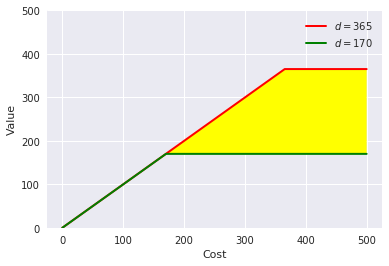

In [3]:
def deductible(c,d):
   return min(c,d)

range_c = np.arange(0,500,0.1)
range_v170 = [deductible(c,170) for c in range_c]
range_v365 = [deductible(c,365) for c in range_c]

plt.plot(range_c,range_v365,'-', color = 'r', linewidth = 2, label = '$d=365$')
plt.plot(range_c,range_v170,'-', color = 'g', linewidth = 2, label = '$d=170$')
plt.legend()
plt.fill_between(range_c, range_v170, range_v365, facecolor='yellow')
plt.ylim(0,500)
plt.xlabel('Cost')
plt.ylabel('Value')
plt.show()


## some data



To find the effect of an increase in deductible, we compare health care expenditures in the years 2011 (deductible was 170 euro) and 2014 (deductible was 365 euro). We use data from [Vektis](http://www.vektis.nl/index.php/vektis-open-data). Download from this website the 'csv' files for 2011 and 2014. To use the code below, download these csv-files into the sub-directory "data" (i.e. "data" is sub-directory of the directory in which this notebook resides). 

When you open the csv files, you can see that it uses ";" as separator between columns. Hence, we use pandas' `read_csv` statement where we specify the separator as ';'. The data contain total cost per postal code area for a number of cost categories. The expenditures are grouped by sex and age.

The function `get_data_into_shape` does a number of things:

-   not all health care cost categories in the data "count" as far as the deductible is concerned. Hence, we select the ones that fall under the deductible and sum these as the relevant total expenditure under the deductible.
-   the cost categories are in Dutch, hence we translate the labels into English
-   we drop variables that we do not need for the analysis here
-   we calculate cost per head per postal code area
-   we also introduce the log of health care costs per head
-   we turn the variable `sex` into a category with two values ('M' for males, 'V' for females)
-   we drop the age category '91+' and turn the remaining ages into integers
-   finally, the function returns this new dataframe.

The function illustrates the data manipulation you can do with pandas. We use the same function for the 2011 and 2014 data, which means that we ignore some columns in the 2014 data that are not available in the 2011 data.



In [4]:
df_2014 = pd.read_csv('data/Vektis Open Databestand Zorgverzekeringswet 2014 - postcode3.csv', sep = ';')

cost_categories_under_deductible = ['KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG', 'KOSTEN_MONDZORG', 'KOSTEN_FARMACIE', 'KOSTEN_HULPMIDDELEN', 'KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE', 'KOSTEN_PARAMEDISCHE_ZORG_OVERIG', 'KOSTEN_ZIEKENVERVOER_ZITTEND', 'KOSTEN_ZIEKENVERVOER_LIGGEND', 'KOSTEN_GRENSOVERSCHRIJDENDE_ZORG', 'KOSTEN_OVERIG']

def get_data_into_shape(df):
    df['health_expenditure_under_deductible'] = df[cost_categories_under_deductible].sum(axis=1)
    df = df.rename({
        'GESLACHT':'sex',
        'LEEFTIJDSKLASSE':'age',
        'GEMEENTENAAM':'MUNICIPALITY',
        'AANTAL_BSN':'number_citizens',
        'KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG':'hospital_care',
        'KOSTEN_FARMACIE':'pharmaceuticals',
        'KOSTEN_TWEEDELIJNS_GGZ':'mental_care',
        'KOSTEN_HUISARTS_INSCHRIJFTARIEF':'GP_capitation',
        'KOSTEN_HUISARTS_CONSULT':'GP_fee_for_service',
        'KOSTEN_HUISARTS_OVERIG':'GP_other',
        'KOSTEN_MONDZORG':'dental care',
        'KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE':'physiotherapy',
        'KOSTEN_KRAAMZORG':'maternity_care',
        'KOSTEN_VERLOSKUNDIGE_ZORG':'obstetrics'
    }, axis='columns')
    df.drop(['AANTAL_VERZEKERDEJAREN',
             'KOSTEN_HULPMIDDELEN',
             'KOSTEN_PARAMEDISCHE_ZORG_OVERIG',
             'KOSTEN_ZIEKENVERVOER_ZITTEND',
             'KOSTEN_ZIEKENVERVOER_LIGGEND',
             'KOSTEN_GRENSOVERSCHRIJDENDE_ZORG',
             'KOSTEN_OVERIG',
             'KOSTEN_EERSTELIJNS_ONDERSTEUNING'],inplace=True,axis=1)
    df.drop(df.index[[0]], inplace=True)
    df['sex'] = df['sex'].astype('category')
    df['age'] = df['age'].astype('category')
    df['costs_per_head']=df['health_expenditure_under_deductible']/df['number_citizens']
    df['log_costs_per_head']=np.log(1+df['health_expenditure_under_deductible']/df['number_citizens'])
    df = df[(df['age'] != '90+')]
    df['age'] = df['age'].astype(int)
    return df

df_2014 = get_data_into_shape(df_2014)
df_2014.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sex,age,POSTCODE_3,number_citizens,hospital_care,pharmaceuticals,KOSTEN_SPECIALISTISCHE_GGZ,GP_capitation,GP_fee_for_service,GP_other,dental care,physiotherapy,maternity_care,obstetrics,KOSTEN_GENERALISTISCHE_BASIS_GGZ,KOSTEN_GERIATRISCHE_REVALIDATIEZORG,health_expenditure_under_deductible,costs_per_head,log_costs_per_head
1,M,0,0.0,366,1372209.26,31191.20,285.98,5548.60,5540.05,11525.93,681.02,12150.91,0.0,0.0,0.0,0.0,1425823.15,3895.691667,8.267883
2,M,0,101.0,590,1682944.17,25898.73,20774.91,9816.63,10130.12,20532.03,0.00,17777.00,0.0,0.0,0.0,0.0,1753560.87,2972.137068,7.997373
3,M,0,102.0,295,1553933.53,29514.18,7970.01,5317.49,6576.70,17426.30,21.29,20459.17,0.0,0.0,0.0,0.0,1617184.58,5481.981627,8.609404
4,M,0,103.0,288,827427.31,19263.79,941.40,5014.97,5708.41,14168.90,0.00,9098.71,0.0,0.0,0.0,0.0,865867.07,3006.482882,8.008859
5,M,0,105.0,998,2965316.12,61610.42,4780.48,16842.06,19676.01,43794.06,166.98,42332.18,0.0,0.0,0.0,0.0,3118357.71,3124.606924,8.047384


We create `costs_per_sex_age` which contains the average health care expenditure (averaged over postal code areas) for each combination of sex and age in the data. For this we use `pandas` method `groupby`.

The outcome of this `groupby` we plot below.



In [40]:
costs_per_sex_age = df_2014.groupby(['sex','age'])['costs_per_head'].mean()


## matplotlib



We plot the distribution of health care expenditure per head with age for males and females.



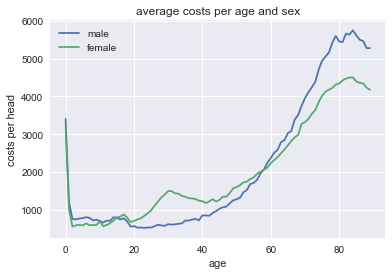

In [41]:
fig = plt.figure()
ax = costs_per_sex_age['M'].plot()
ax = costs_per_sex_age['V'].plot()
ax.set_xlabel('age')
ax.set_ylabel('costs per head')
ax.set_title('average costs per age and sex')
ax.legend(['male','female'])

**Question** Can you interpret how these costs evolve with age and sex?

**Question** How can a graph like this help us to determine the effect of $d$ on health care expenditure?




## reversing the probability distributions



Above we used `pymc3` to generate vectors of productivities, valuations, incomes etc. using probability distributions. Here we go the "other way around". We have here distributions of health care expenditures per head and we want to identify the distributions where these come from. To illustrate this, consider the distribution of (average) costs for 30 year old males. Since, health care costs have a skewed distribution, we actually plot the distribution of log costs.

**Question** Plot health care cost distributions for different age and sex categories.



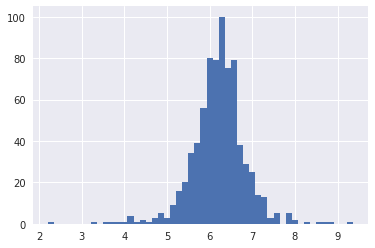

In [5]:
df_2014.query('sex=="M" & age=="30"')['log_costs_per_head'].hist(bins=50)

This distribution looks (sort of) normal. Hence, we assume that for each age and sex category `log_costs_per_head` are normally distributed. This implies that `costs_per_head` have a log-normal distribution.

**Question** Why are there no zeroes in this figure? Lots of people have no health care expenditure in a year? How does our `log_costs_per_head` deal with zero costs? Should there be a spike at 0?

We focus here on health care costs for women. Clearly, a similar analysis can be done for men. In fact, it is also possible to combine men and women into one analysis with gender fixed effects.

Here we focus on women and introduce age-fixed effects. We assume that observed costs $z$ are `log_costs_per_head` which are normally distributed with a mean $\mu$ and standard deviation $\sigma$ which both vary with age. We do not know these means and standard deviations `μ[age], σ[age]` but assume they are drawn from prior distributions. A [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) for $\mu$ and a half-normal distribution for $\sigma$.

This is called a Bayesian analysis which you probably never saw before. Do not worry about this; you do not need to understand the details of this analysis. If you find it interesting, there are some references at the end.



In [6]:
log_costs_per_age_female = df_2014[df_2014['sex']=='V'].groupby(['age'])['log_costs_per_head'].mean()

log_costs_per_head = df_2014[df_2014['sex']=='V'].log_costs_per_head.values
age = df_2014[df_2014['sex']=='V'].age.values


with pm.Model() as model:
    
    μ = pm.Normal('μ', 8, 3, shape=len(set(age)))
    σ = pm.HalfNormal('σ', 4, shape=len(set(age)))
    z = pm.Normal('z', μ[age], σ[age], observed=log_costs_per_head)

In [7]:
with model:
    trace = pm.sample(4000,step = pm.Metropolis(),start = pm.find_MAP())

logp = -32,663, ||grad|| = 1.6716: 100%|██████████| 34/34 [00:01<00:00, 21.96it/s]      
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [μ]
Sampling 2 chains: 100%|██████████| 9000/9000 [11:07<00:00, 14.57draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


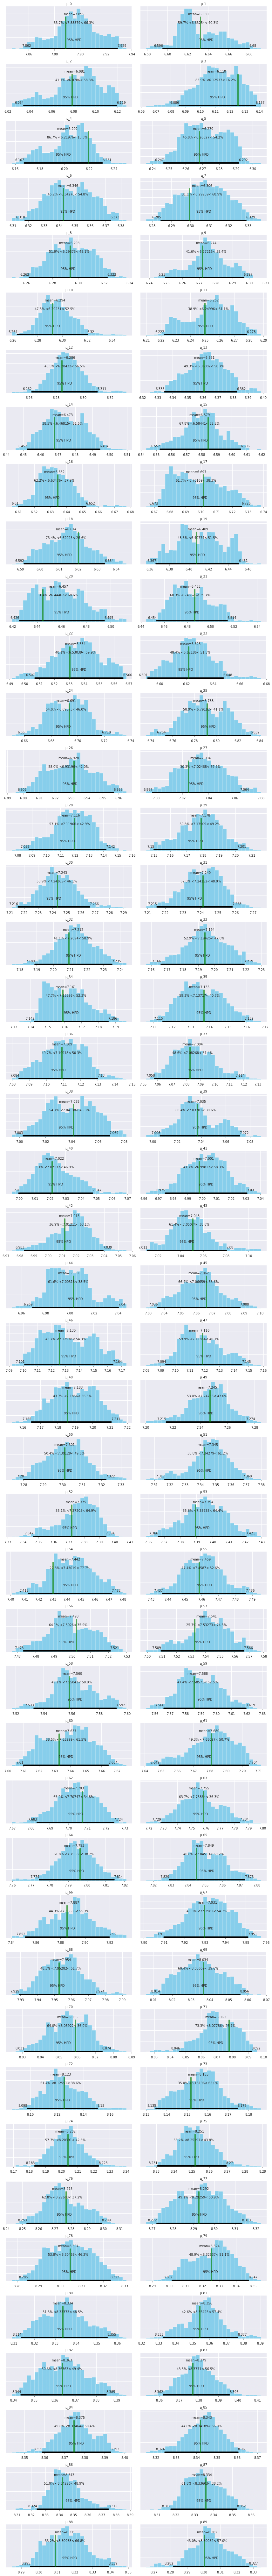

In [9]:
summary = pm.summary(trace, varnames=['μ'])

pm.plot_posterior(trace, varnames=['μ'],ref_val = log_costs_per_age_female.values)[0]

The figures above compare the estimated distribution for $\mu$ for each age category with the observed average expenditure for this age category in the data. The observed average expenditure falls in the middle of this distribution for each age category. This suggests that the estimation makes some sense (although more tests should be done). 

The "fun" of Bayesian analysis is that we have a (posterior) distribution of the population parameters $\mu$. With "classic" econometrics this is not possible, since $\mu$ is not random in that analysis.

To elaborate a little, in classical econometric analysis we consider the probability $p(\text{data}|\theta)$ where $\theta$ denotes the parameters of the underlying distribution. Hence, we do $p(m>10|\mu=9)$. With Bayes, we do $p(\theta|\text{data})$. The idea is that the data is fixed (we have observed it) but we face uncertainty over the values of the parameters $\theta$. The graphs above plot for each age the distribution of $\mu$.

Now we can plot the average $\mu$ for each age and the observed average expenditure per age category in a graph:



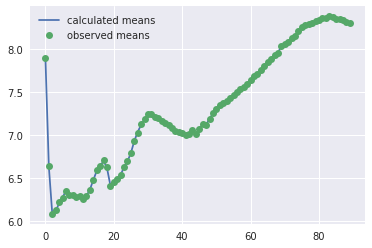

In [10]:
plt.plot(summary['mean'].values,label='calculated means')
plt.plot(log_costs_per_age_female,'o',label='observed means')
plt.legend()

To see the effect of the deductible, we compare the average $\mu$ for 17 year olds with the average $\mu$ for 19 year olds:

In [47]:
summary['mean']['μ__17'] - summary['mean']['μ__19']

0.2944036693992409

This is positive: 17 year olds spend more on health care than 19 year olds. Now you may think that although the average $\mu$ is higher for 17 year olds than for 19 year olds, but perhaps it is still likely that $\mu_{19}>\mu_{17}$. Hence we plot these $\mu$ distributions:



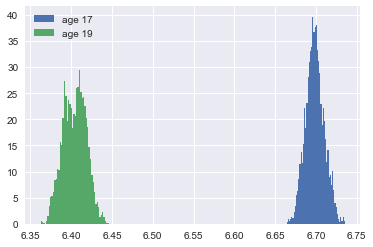

In [48]:
plt.hist(trace['μ'][:,17],density=True,label='age 17',bins=50)
plt.hist(trace['μ'][:,19],density=True,label='age 19',bins=50)
plt.legend()

**Question** Does this mean that expenditure of every 17 year old exceeds the expenditure of every 19 year old?

**Questions** Focus on 19 year olds. What is the probability that $\mu_{19}>6.45$?

In [11]:
np.sum(trace['μ'][:,19]>6.45)/len(trace['μ'][:,19])

0.0205

One explanation for the figure is that 17 year olds do not face a deductible, while 19 year olds do. But an other explanation is that health care expenditure simply differs by age (irrespective of a deductible). In order to control for the age effect, we re-do the analysis above for 2011. Also in 2011 we can take the difference in means for 17 and 19 year olds. If there is (only) a biological reason for the different expenditures between 17 and 19 year olds, the difference in 2011 should be the same as the difference in 2014. 

If, however, the difference in expenditures is caused by the deductible, we expect a bigger difference in 2014 than in 2011 as the deductible was higher in 2014 than in 2011. In terms of our model above: the yellow area is the additional effect due to the higher deductible in 2014.

Hence, we do the same analysis as above for 2011.

In [49]:
df_2011 = pd.read_csv('data/Vektis Open Databestand Zorgverzekeringswet 2011 - postcode3.csv', sep = ';')

df_2011 = get_data_into_shape(df_2011)
df_2011.head()

/Users/boone/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sex,age,POSTCODE_3,number_citizens,hospital_care,pharmaceuticals,mental_care,GP_capitation,GP_fee_for_service,GP_other,dental care,physiotherapy,maternity_care,obstetrics,KOSTEN_EERSTELIJNS_PSYCHOLOGISCHE_ZORG,health_expenditure_under_deductible,costs_per_head,log_costs_per_head
1,M,0,0.0,399,673096.28,24352.91,6249.19,4878.50,5508.93,8312.85,0.0,10708.89,0.0,0.0,0.0,774533.05,1941.185589,7.571569
2,M,0,101.0,608,1141314.40,17499.50,6303.31,10469.99,12216.49,22939.00,0.0,10272.41,0.0,0.0,0.0,1196589.65,1968.075082,7.585319
3,M,0,102.0,300,570651.81,15431.84,6563.82,5346.37,6815.20,13641.15,0.0,4090.89,0.0,0.0,0.0,605038.59,2016.795300,7.609761
4,M,0,103.0,287,1459149.63,42044.17,6348.12,5039.63,6317.01,13070.23,0.0,3732.10,0.0,0.0,0.0,1661669.25,5789.788328,8.664024
5,M,0,105.0,1049,3036501.62,59187.46,41053.58,18076.34,21496.57,46877.41,0.0,14180.39,0.0,0.0,0.0,3172935.43,3024.723956,8.014906


As above we estimate the model.



In [50]:
log_costs_per_age_female = df_2011[df_2011['sex']=='V'].groupby(['age'])['log_costs_per_head'].mean()

log_costs_per_head = df_2011[df_2011['sex']=='V'].log_costs_per_head.values
age = df_2011[df_2011['sex']=='V'].age.values


with pm.Model() as model_2011:
    
    μ = pm.Normal('μ', 8, 3, shape=len(set(age)))
    σ = pm.HalfCauchy('σ', 4, shape=len(set(age)))
    z = pm.Normal('z', μ[age], σ[age], observed=log_costs_per_head)

In [51]:
with model_2011:
    trace_2011 = pm.sample(4000,step = pm.Metropolis(),start = pm.find_MAP())

logp = -26,948, ||grad|| = 36.313: 100%|██████████| 30/30 [00:00<00:00, 259.43it/s]   
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [σ_log__]
INFO:pymc3:>Metropolis: [σ_log__]
>Metropolis: [μ]
INFO:pymc3:>Metropolis: [μ]
100%|██████████| 4500/4500 [00:22<00:00, 197.33it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [52]:
summary_2011 = pm.summary(trace_2011, varnames=['μ'])

Recall that in 2014 the difference in mean log expenditure equals:

In [55]:
summary['mean']['μ__17']-summary['mean']['μ__19']

0.2944036693992409

In 2011, this difference is smaller:

In [56]:
summary_2011['mean']['μ__17']-summary_2011['mean']['μ__19']

0.2008784664728278

Also this we can do with distributions.



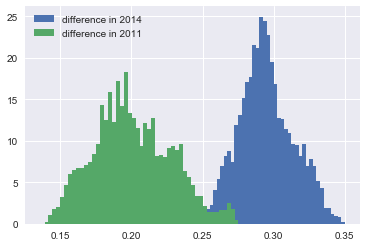

In [57]:
plt.hist(trace['μ'][:,17]-trace['μ'][:,19],density=True,label='difference in 2014',bins=50)
plt.hist(trace_2011['μ'][:,17]-trace_2011['μ'][:,19],density=True,label='difference in 2011',bins=50)

plt.legend()

**Question** Calculate the probability that in fact the parameter difference $\mu_{17}-\mu_{19}$ is bigger in 2011 than in 2014.

Hence we find that government regulation in terms of a deductible has an effect on health care expenditures. People spend less on health care if they face a higher deductible.

One can extend the analysis above to make it more convincing. Think of things like

-   add more years (using the Vektis website)
-   add year dummies to distinguish year effects (like changes in treatments covered by basic insurance) from changes in deductible
-   add the level of the deductible in the estimation.

If you like this way of modelling with pymc3, you can look at [this video](https://www.youtube.com/watch?v=TMmSESkhRtI&t=9076s)

A simple introduction to Bayesian estimation with python can be found [here](https://www.youtube.com/watch?v=TpgiFIGXcT4&t=6s). Allen Downey also has [free books](http://www.allendowney.com/wp/books/) on statistics with python.